<a href="https://colab.research.google.com/github/chi468/aiTemperature/blob/master/aiTemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Tensorflow 설치
#!pip install tensorflow==2.0.0-rc1
#!pip install -q tensorflow-gpu==2.0.0-rc1

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
temperature_name = ["X00","X07","X28","X31","X32"] #기온
localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
speed_name       = ["X02","X03","X18","X24","X26"] #풍속
water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
press_name       = ["X05","X08","X09","X23","X33"] #해면기압
sun_name         = ["X11","X14","X16","X19","X34"] #일일 누적일사량
humidity_name    = ["X12","X20","X30","X37","X38"] #습도
direction_name   = ["X13","X15","X17","X25","X35"] #풍향

In [5]:
# 기상청 데이터만 추출

#X14,X16,X19 제외

#X_train = train.loc[:,'X00':'X39']
#X_train = X_train.drop(['X14','X16','X19','X39'],axis=1)

# 각 기온,기압,... 에서 가장 좋은 한가지 피쳐만을 사용
req_x=['X00','X27','X24','X39','X33','X34','X12','X25']
X_train = train.loc[:,req_x]
test = test.loc[:,req_x]

# 예측 하고자 하는 센서와 가장 비슷한 센서 Y16 사용
y_columns = ['Y16']

X_trainLen = X_train.shape[1]

# standardization을 위해 평균과 표준편차 구하기
MEAN = X_train.mean()
STD = X_train.std()

# 표준편차가 0일 경우 대비하여 1e-07 추가
X_train = (X_train - MEAN) / (STD + 1e-07)

In [6]:
# RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환 
def convert_to_timeseries(df, interval):
    sequence_list = []
    target_list = []
    
    for i in tqdm(range(df.shape[0] - interval)):
        sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
        target_list.append(df.iloc[i+interval,-1])
    
    sequence = np.array(sequence_list)
    target = np.array(target_list)
    
    return sequence, target

In [7]:
# t시점 이전 120분의 데이터로 t시점의 온도를 추정할 수 있는 학습데이터 형성
interval = 12;
#sequence = []
#for _ in range(17):
  #sequence.append(np.empty((0, interval, X_train.shape[1])))


# t시점 이전 120분의 데이터로 t시점의 온도를 추정할 수 있는 학습데이터 형성
sequence = np.empty((0, interval, X_train.shape[1]))
target = np.empty((0,))
for column in y_columns :
    
    concat = pd.concat([X_train, train[column]], axis = 1)

    _sequence, _target = convert_to_timeseries(concat.head(144*30), interval = 12)

    sequence = np.vstack((sequence, _sequence))
    target = np.hstack((target, _target))


100%|██████████| 4308/4308 [00:00<00:00, 4886.33it/s]


In [8]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

#손실함수 4제곱으로 직접 정의
def msse(y_pred, y_true):
    loss = K.mean((y_true-y_pred)**4)
 
    return loss

In [9]:
# lstm 모델 구축하기
simple_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:]),

  tf.keras.layers.Dense(128, activation='relu'),

  tf.keras.layers.Dense(128, activation='relu'),
  
  tf.keras.layers.Dense(1)

])


simple_lstm_model.compile(optimizer='adam', loss='mse')

In [10]:
# loss가 어떤 값 미만으로 떨어지면 학습 종료 시키는 기능
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 0.25):
            print('\n Loss is under 0.25, cancelling training')
            self.model.stop_training = True

In [11]:
callbacks = myCallback()

In [12]:
# 8:2로 train / test 데이터 나눠서 
# validation data 로 활용

dataX = sequence
dataY = target
data_dim = X_trainLen

train_size = int(len(dataY)*0.8)
test_size = len(dataY) - train_size
trainX = np.array(dataX[0:train_size]) ,
testX = np.array(dataX[train_size:len(dataX)])
trainY = np.array(dataY[0:train_size])
testY = np.array(dataY[train_size:len(dataX)])


In [13]:
# 모델 학습
simple_lstm_model.fit(    
    sequence, target,
    epochs=20,
    batch_size=10,
    verbose=1,
    shuffle=False,
    callbacks = [callbacks]
)

Epoch 1/20
431/431 [==============================] - 3s 4ms/step - loss: 78.3409
Epoch 2/20
431/431 [==============================] - 2s 4ms/step - loss: 22.6948
Epoch 3/20
431/431 [==============================] - 2s 4ms/step - loss: 14.2621
Epoch 4/20
431/431 [==============================] - 2s 4ms/step - loss: 12.1577
Epoch 5/20
431/431 [==============================] - 2s 4ms/step - loss: 10.5053
Epoch 6/20
431/431 [==============================] - 2s 4ms/step - loss: 9.9428
Epoch 7/20
431/431 [==============================] - 2s 4ms/step - loss: 8.8238
Epoch 8/20
431/431 [==============================] - 2s 4ms/step - loss: 8.9890
Epoch 9/20
431/431 [==============================] - 2s 4ms/step - loss: 9.3706
Epoch 10/20
431/431 [==============================] - 2s 4ms/step - loss: 8.0794
Epoch 11/20
431/431 [==============================] - 2s 4ms/step - loss: 8.8383
Epoch 12/20
431/431 [==============================] - 2s 5ms/step - loss: 10.1403
Epoch 13/20
431/431

In [14]:
def cal_res(pred,test):
  res = 0
  for i in range(len(pred)):
     res += abs((pred.loc[i]-test.loc[i]))
  return res / len(pred)

100%|██████████| 432/432 [00:00<00:00, 4657.68it/s]
          0         1
0  1.000000  0.906089
1  0.906089  1.000000
     0    1
0  1.0 -1.0
1 -1.0  1.0


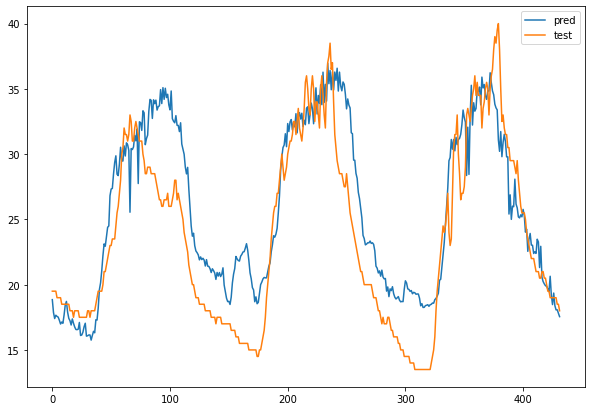

In [15]:
# Y16 센서 예측값 및 실제값 그래프로 표현

testX, _ = convert_to_timeseries(pd.concat([X_train.tail(144*3+12),train['Y00'].tail(144*3+12)],axis=1), interval = 12)
y_pred = pd.DataFrame(simple_lstm_model.predict(testX))
cor_test = pd.concat([y_pred, train['Y18'].tail(144*3).reset_index(drop=True)],ignore_index=True,axis=1).corr()
print(cor_test)
cor = cor_test.corr()
print(cor)

testY = np.array(testY)

plt.figure(figsize=(10,7))
plt.plot(y_pred)
plt.plot(testY[:len(y_pred)])
plt.legend(['pred','test'])


In [16]:
testY_series=pd.Series(testY[:len(y_pred)])
testY_series

0      19.5
1      19.5
2      19.5
3      19.5
4      19.0
       ... 
427    19.0
428    19.0
429    18.5
430    18.5
431    18.0
Length: 432, dtype: float64

In [19]:
cal_res(y_pred,testY_series)

0    3.075705
Name: 0, dtype: float32

In [18]:
testY = train['Y16']

In [20]:
# convert_to_timeseries 함수를 쓰기 위한 dummy feature 생성
X_train['dummy'] = 0
# train set에서 도출된 평균과 표준편차로 standardization 실시 
test = (test - MEAN) / (STD + 1e-07)
# convert_to_timeseries 함수를 쓰기 위한 dummy feature 생성
test['dummy'] = 0
# train과 test 기간을 합쳐서 120분 간격으로 학습데이터 재구축
X_test, _ = convert_to_timeseries(pd.concat([X_train, test], axis = 0), interval=12)
# test set 기간인 후반부 80일에 맞게 자르기 
X_test = X_test[-11520:, :, :]
# 만들어 두었던 dummy feature 제거
X_train.drop('dummy', axis = 1, inplace = True)
test.drop('dummy', axis = 1, inplace = True)

print(test.shape)

100%|██████████| 16260/16260 [00:03<00:00, 5061.50it/s](11520, 8)



In [21]:
# LSTM 레이어는 고정
simple_lstm_model.layers[0].trainable = False
# fine tuning 할 때 사용할 학습데이터 생성 (Y18)
finetune_X, finetune_y = convert_to_timeseries(pd.concat([X_train.tail(432), train['Y18'].tail(432)], axis = 1), interval=12)

# LSTM 레이어는 고정 시켜두고, DNN 레이어에 대해서 fine tuning 진행 (Transfer Learning)
finetune_history = simple_lstm_model.fit(
            finetune_X, finetune_y,
            epochs=1,
            batch_size=10,
            shuffle=False,
            verbose = 0)



100%|██████████| 420/420 [00:00<00:00, 4785.64it/s]


In [22]:
# 예측하기 
print(X_test.shape)
finetune_pred = simple_lstm_model.predict(X_test)

(11520, 12, 8)


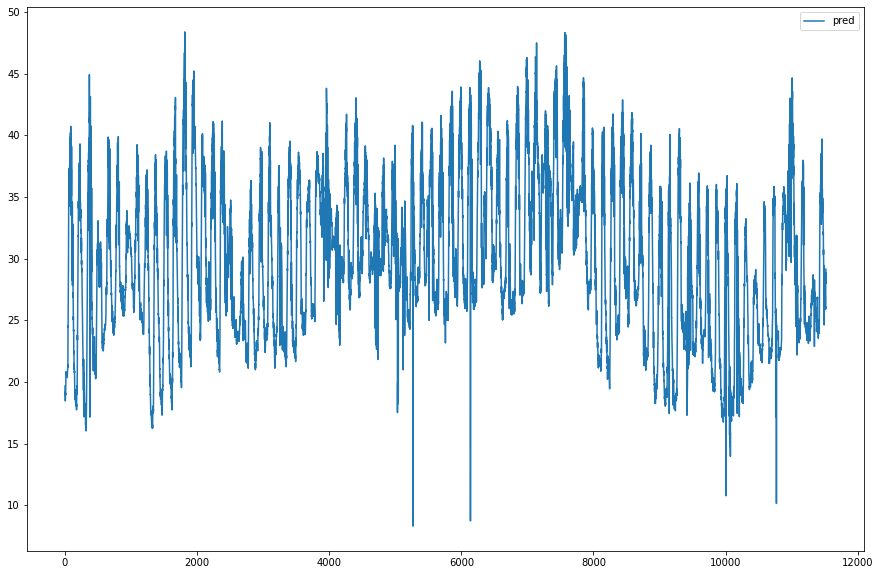

In [23]:
plt.figure(figsize=(15,10))
plt.plot(finetune_pred)
plt.legend(['pred'])

In [24]:
acc = tf.keras.metrics.Accuracy(
    name='accuracy', dtype=None
)

In [25]:
# 제출용 DataFrame 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':finetune_pred.reshape(1,-1)[0]})